# Установка и импорт

In [ ]:
!curl -L "https://app.roboflow.com/ds/cBt8jXQW7V?key=xCqn31zFvq" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
!cp /content/drive/MyDrive/BIOCAD/dataset.zip dataset.zip; unzip dataset.zip; rm dataset.zip

In [1]:
!cp /content/drive/MyDrive/BIOCAD/splitted_dataset.zip dataset.zip; unzip dataset.zip; rm dataset.zip

Archive:  dataset.zip
   creating: train/
   creating: train/labels/
  inflating: train/labels/video_2023-07-04_12-11-16_132_jpg.rf.8c7d40a8c0ce1d5ed31700ca6f4c58d9.txt  
  inflating: train/labels/video_2023-07-04_12-03-45_15_jpg.rf.f3b77c78d1fee39f9d380ba2afa2e369.txt  
  inflating: train/labels/video_2023-07-04_11-55-24_12_jpg.rf.98e44fffb6f56c617b6e2daaa76688b5.txt  
  inflating: train/labels/video_2023-07-04_11-39-04_672_jpg.rf.50e3c4434b8411b0247ef84121072a9e.txt  
  inflating: train/labels/video_2023-07-04_12-03-45_11_jpg.rf.dac786e105501488f80d0dd9b7155b7e.txt  
  inflating: train/labels/video_2023-07-04_12-06-09_47_jpg.rf.4d883cbaeaeab17b2556605e8048c46e.txt  
  inflating: train/labels/video_2023-07-04_11-50-46_324_jpg.rf.34fd99b10c9be620b830f9dc266181b5.txt  
  inflating: train/labels/video_2023-07-04_12-03-45_18_jpg.rf.cc256767983c0a3ba6cd26030db50765.txt  
  inflating: train/labels/video_2023-07-04_12-00-12_132_jpg.rf.00d432d90b7a3c3dc78325771c09891a.txt  
  inflating: train

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.9/626.9 kB 19.8 MB/s eta 0:00:00


In [3]:
from google.colab.patches import cv2_imshow
import yaml
import os
import cv2
import random
import hashlib
from ultralytics import YOLO

random.seed(int(hashlib.sha512("бубибу".encode("utf-8")).hexdigest(), 16))

# Замена повторных классов

In [4]:
replace = {
    "suit": "suit",
    "hood1": "hood",
    "shoe_covers1": "shoe",
    "mask_0": "no_mask",
    "mask_1": "mask",
    "glasses1": "glasses",
    "mask0": "no_mask",
    "suit_0": "no_suit",
    "glove": "glove",
    "glove_0": "no_glove",
    "glass_0": "no_glasses",
    "hood0": "no_hood",
    "hood_1": "hood",
    "shoe": "shoe",
    "suit0": "no_suit",
    "suit_1": "suit",
    "hood_0": "no_hood",
    "shoe_covers0": "no_shoe",
    "glove1": "glove",
    "glove_1": "glove",
    "maske": "mask",
    "shoe_0": "no_shoe",
    "shoe_1": "shoe",
    "glove0": "no_glove",
    "mask1": "mask",
    "hood": "hood",
    "glasses0": "no_glasses",
    "suit1": "suit",
    "glass_1": "glasses"
}

In [5]:
with open("/content/data.yaml", "r") as f:
  data = yaml.safe_load(f)

names = data["names"]
new_names = []
for x in names:
  x = replace[x]
  if x not in new_names:
    new_names.append(x)

repl = [-1 for i in names]
for i in range(len(names)):
  repl[i] = new_names.index(replace[names[i]])

data["nc"] = len(new_names)
data["names"] = new_names

with open("/content/data.yaml", "w") as f:
  yaml.dump(data, f)

data

{'train': '../train/images',
 'val': '../valid/images',
 'test': '../test/images',
 'nc': 12,
 'names': ['no_glasses',
  'glasses',
  'no_glove',
  'glove',
  'no_hood',
  'hood',
  'no_mask',
  'mask',
  'no_shoe',
  'shoe',
  'no_suit',
  'suit'],
 'roboflow': {'workspace': 'dima-l-qblqg',
  'project': 'siz_dataset',
  'version': 1,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/dima-l-qblqg/siz_dataset/dataset/1'}}

In [6]:
path = "/content/train/labels"

for label in os.listdir(path):
  with open(f"{path}/{label}", "r") as f:
    w = f.read().strip().split("\n")
  if len(w) == 0 or w[0] == "":
    continue
  for i in range(len(w)):
    w[i] = w[i].split()
    w[i][0] = str(repl[int(w[i][0])])
    w[i] = " ".join(w[i])
  out = "\n".join(w)

  with open(f"{path}/{label}", "w") as f:
    f.write(out)

# Сжатие bounding boxes

In [7]:
label_path = "/content/train/labels"
image_path = "/content/train/images"

for lbl_path in os.listdir(label_path):
  img_path = f"{image_path}/{lbl_path.replace('.txt', '.jpg')}"
  img = cv2.imread(img_path)

  with open(f"{label_path}/{lbl_path}", "r") as f:
    label = f.read().strip().split("\n")

  label = list(map(lambda x: x.split(), label))
  if len(label) == 0 or len(label[0]) == 0:
    os.remove(img_path)
    os.remove(f"{label_path}/{lbl_path}")
    continue

  label = list(map(lambda x: [int(x[0]), float(x[1]), float(x[2]), float(x[3]), float(x[4])], label))

  h, w, _ = img.shape
  mn_x, mx_x = 1, 0
  mn_y, mx_y = 1, 0

  for ind, x, y, width, height in label:

    mn_x = min(mn_x, x - width / 2)
    mx_x = max(mx_x, x + width / 2)

    mn_y = min(mn_y, y - height / 2)
    mx_y = max(mx_y, y + height / 2)

  rnd_bound = random.random() * 0.05

  mn_x = max(0, mn_x - rnd_bound)
  mx_x = min(1, mx_x + rnd_bound)

  mn_y = max(0, mn_y - rnd_bound)
  mx_y = min(1, mx_y + rnd_bound)

  for i in range(len(label)):
    x0 = label[i][1] - label[i][3] / 2
    x1 = label[i][1] + label[i][3] / 2
    y0 = label[i][2] - label[i][4] / 2
    y1 = label[i][2] + label[i][4] / 2

    x0 = (x0 - mn_x) / (mx_x - mn_x)
    x1 = (x1 - mn_x) / (mx_x - mn_x)
    y0 = (y0 - mn_y) / (mx_y - mn_y)
    y1 = (y1 - mn_y) / (mx_y - mn_y)


    label[i][1] = (x0 + x1) / 2
    label[i][2] = (y0 + y1) / 2
    label[i][3] = x1 - x0
    label[i][4] = y1 - y0
    label[i] = " ".join(map(str, label[i]))

  label = "\n".join(label)

  mn_x, mx_x, mn_y, mx_y = map(int, (mn_x * w, mx_x * w, mn_y * h, mx_y * h))
  img = img[mn_y:mx_y, mn_x:mx_x]

  h, w, _ = img.shape

  with open(f"{label_path}/{lbl_path}", "w") as f:
    f.write(label)

  cv2.imwrite(img_path, img)

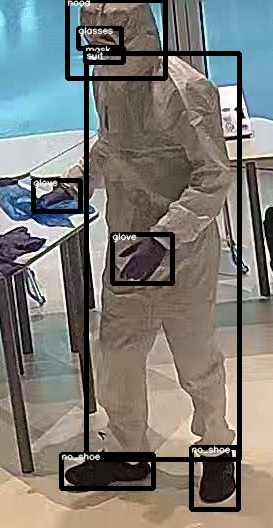

In [20]:
label = f"/content/train/labels/{os.listdir('/content/train/labels')[0]}"
img = label.replace("/labels/", "/images/").replace(".txt", ".jpg")

def show_pred(img, label):
  img = cv2.imread(img)
  with open(label, "r") as f:
    label = f.read().split("\n")

  label = list(map(lambda x: x.split(), label))
  label = list(map(lambda x: [int(x[0]), float(x[1]), float(x[2]), float(x[3]), float(x[4])], label))

  h, w, _ = img.shape

  for ind, x, y, width, height in label:
    width /= 2
    height /= 2

    cv2.rectangle(
        img,
        (int((x - width) * w), int((y - height) * h)),
        (int((x + width) * w), int((y + height) * h)),
        (0, 0, 0), 4
    )

    cv2.putText(
        img,
        data["names"][ind],
        (int((x - width) * w), int((y - height) * h) + 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.3,
        (255, 255, 255),
        1,
        cv2.LINE_AA
    )

  cv2_imshow(img)

show_pred(img, label)

# Разделение датасета

In [21]:
videos = set()

for label in os.listdir("/content/train/labels/"):
  name = label.split("_")
  videos.add("_".join(name[:3]))

videos = list(videos)

print(videos)
print("Total:", len(videos))

['video_2023-07-04_11-58-05', 'video_2023-07-04_12-03-01', 'video_2023-07-04_12-03-45', 'video_2023-07-04_11-53-24', 'video_2023-07-04_12-19-37', 'video_2023-07-04_12-12-14', 'video_2023-07-04_12-04-35', 'video_2023-07-04_11-49-56', 'video_2023-07-04_12-11-16', 'video_2023-07-04_12-06-09', 'video_2023-07-04_11-50-46', 'video_2023-07-04_12-10-06', 'video_2023-07-04_12-23-41', 'video_2023-07-04_11-39-04', 'video_2023-07-04_12-16-26', 'video_2023-07-04_11-56-06', 'video_2023-07-04_12-10-40', 'video_2023-07-04_12-12-51', 'video_2023-07-04_12-00-12', 'video_2023-07-04_12-21-07', 'video_2023-07-04_12-18-24', 'video_2023-07-04_11-55-24']
Total: 22


In [23]:
ratio = {
    "train": 0.7,
    "valid": 0.15,
    "test": 0.15
}

random.shuffle(videos)
n = len(videos)
c = 0
t = 0

video_map = dict()

i = 0
for k in ratio.keys():
  t += ratio[k]
  while c / n < t:
    video_map[videos[i]] = k
    i += 1
    c += 1

video_map

{'video_2023-07-04_12-00-12': 'train',
 'video_2023-07-04_12-18-24': 'train',
 'video_2023-07-04_11-55-24': 'train',
 'video_2023-07-04_12-12-51': 'train',
 'video_2023-07-04_12-19-37': 'train',
 'video_2023-07-04_12-10-06': 'train',
 'video_2023-07-04_11-53-24': 'train',
 'video_2023-07-04_12-23-41': 'train',
 'video_2023-07-04_11-58-05': 'train',
 'video_2023-07-04_11-49-56': 'train',
 'video_2023-07-04_11-39-04': 'train',
 'video_2023-07-04_12-06-09': 'train',
 'video_2023-07-04_11-50-46': 'train',
 'video_2023-07-04_12-03-45': 'train',
 'video_2023-07-04_12-11-16': 'train',
 'video_2023-07-04_12-10-40': 'train',
 'video_2023-07-04_12-16-26': 'valid',
 'video_2023-07-04_12-04-35': 'valid',
 'video_2023-07-04_12-21-07': 'valid',
 'video_2023-07-04_12-12-14': 'test',
 'video_2023-07-04_11-56-06': 'test',
 'video_2023-07-04_12-03-01': 'test'}

In [24]:
for k in ratio.keys():
  q = [f"/content/{k}", f"/content/{k}/images", f"/content/{k}/labels"]
  for path in q:
    if not os.path.exists(path):
      os.mkdir(path)

In [25]:
label_path = "/content/train/labels"
image_path = "/content/train/images"

for label in os.listdir(label_path):
  video_name = "_".join(label.split("_")[:3])
  img = f"{image_path}/{label.replace('.txt', '.jpg')}"
  label = f"{label_path}/{label}"

  d = video_map[video_name]
  os.rename(img, img.replace("/train/", f"/{d}/"))
  os.rename(label, label.replace("/train/", f"/{d}/"))

# Сохранение датасета

In [26]:
!zip -r /content/drive/MyDrive/BIOCAD/splitted_dataset.zip train test valid data.yaml

  adding: train/ (stored 0%)
  adding: train/labels/ (stored 0%)
  adding: train/labels/video_2023-07-04_12-11-16_132_jpg.rf.8c7d40a8c0ce1d5ed31700ca6f4c58d9.txt (deflated 51%)
  adding: train/labels/video_2023-07-04_12-03-45_15_jpg.rf.f3b77c78d1fee39f9d380ba2afa2e369.txt (deflated 53%)
  adding: train/labels/video_2023-07-04_11-55-24_12_jpg.rf.98e44fffb6f56c617b6e2daaa76688b5.txt (deflated 51%)
  adding: train/labels/video_2023-07-04_11-39-04_672_jpg.rf.50e3c4434b8411b0247ef84121072a9e.txt (deflated 52%)
  adding: train/labels/video_2023-07-04_12-03-45_11_jpg.rf.dac786e105501488f80d0dd9b7155b7e.txt (deflated 52%)
  adding: train/labels/video_2023-07-04_12-06-09_47_jpg.rf.4d883cbaeaeab17b2556605e8048c46e.txt (deflated 51%)
  adding: train/labels/video_2023-07-04_11-50-46_324_jpg.rf.34fd99b10c9be620b830f9dc266181b5.txt (deflated 51%)
  adding: train/labels/video_2023-07-04_12-03-45_18_jpg.rf.cc256767983c0a3ba6cd26030db50765.txt (deflated 53%)
  adding: train/labels/video_2023-07-04_12-0

# Обучение модели

In [4]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 21.2MB/s]


In [5]:
model.train(data="data.yaml", epochs=30)

Ultralytics YOLOv8.0.131 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify

In [33]:
img_path = f"/content/test/images/{os.listdir('/content/test/images')[3]}"
results = model.predict(source=img_path, conf=0.5)


image 1/1 /content/test/images/video_2023-07-04_11-56-06_1128_jpg.rf.2c06be64477e927344438b0e3e4952fd.jpg: 640x384 1 glasses, 2 gloves, 1 hood, 1 mask, 2 shoes, 1 suit, 11.2ms
Speed: 3.3ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


In [34]:
img = results[0].orig_img
classes = results[0].names

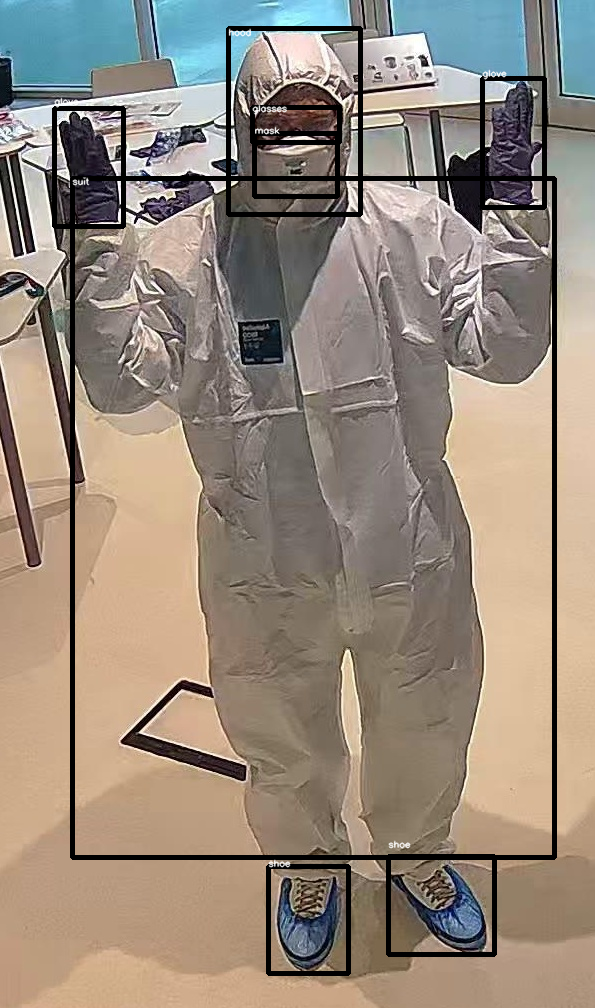

In [35]:
for i in range(len(results[0].boxes.cls)):
  cv2.rectangle(
    img,
    list(map(int, results[0].boxes.xyxy[i][:2].tolist())),
    list(map(int, results[0].boxes.xyxy[i][2:].tolist())),
     (0, 0, 0),
    4
  )

  xn, yn = map(int, results[0].boxes.xyxy[i][:2].tolist())
  yn += int((random.random() - 0.5) * 20)

  cv2.putText(
    img,
    classes[int(results[0].boxes.cls[i])],
    (xn, yn),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.3,
    (255, 255, 255),
    1,
    cv2.LINE_AA
  )

cv2_imshow(img)

In [44]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [46]:
!zip -r /content/drive/MyDrive/BIOCAD/output.zip /content/runs/detect/train

  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/val_batch0_labels.jpg (deflated 8%)
  adding: content/runs/detect/train/results.png (deflated 7%)
  adding: content/runs/detect/train/train_batch1.jpg (deflated 5%)
  adding: content/runs/detect/train/F1_curve.png (deflated 4%)
  adding: content/runs/detect/train/val_batch2_labels.jpg (deflated 7%)
  adding: content/runs/detect/train/val_batch0_pred.jpg (deflated 7%)
  adding: content/runs/detect/train/args.yaml (deflated 52%)
  adding: content/runs/detect/train/results.csv (deflated 84%)
  adding: content/runs/detect/train/weights/ (stored 0%)
  adding: content/runs/detect/train/weights/last.pt (deflated 9%)
  adding: content/runs/detect/train/weights/best.pt (deflated 9%)
  adding: content/runs/detect/train/P_curve.png (deflated 5%)
  adding: content/runs/detect/train/labels_correlogram.jpg (deflated 38%)
  adding: content/runs/detect/train/train_batch0.jpg (deflated 5%)
  adding: content/runs/detect